In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, f1_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset


In [4]:
df = pd.read_csv("output.csv")
df.dropna(subset=["codeLink", "vul"], inplace=True)

print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["vul"].value_counts())

df.head()


Dataset Shape: (5000, 36)

Class Distribution:
vul
0    4715
1     285
Name: count, dtype: int64


,Unnamed: 0,Access Gained,Attack Origin,Authentication Required,Availability,CVE ID,CVE Page,CWE ID,Complexity,Confidentiality,...,lang,lines_after,lines_before,parentID,patch,project,project_after,project_before,vul,vul_func_with_fix
0,0,NaN,Remote,Single system,Partial,CVE-2015-8467,https://www.cvedetails.com/cve/CVE-2015-8467/,CWE-264,Medium,Partial,...,C,NaN,NaN,a819d2b440aafa3138d95ff6e8b824da885a70e9,"@@ -1558,12 +1558,15 @@ static int samldb_chec...",samba,https://git.samba.org/?p=samba.git;a=blob;f=so...,https://git.samba.org/?p=samba.git;a=blob;f=so...,0,static bool check_rodc_critical_attribute(stru...
1,158359,NaN,Remote,Not required,NaN,CVE-2018-17467,https://www.cvedetails.com/cve/CVE-2018-17467/,CWE-20,Medium,NaN,...,C,NaN,NaN,NaN,"@@ -1196,19 +1196,8 @@ void RenderWidgetHostIm...",Chrome,7da6c3419fd172405bcece1ae4ec6ec8316cd345,a1ba6de379939f236565a27cc22d1940bcd867f1,0,void RenderWidgetHostImpl::SetCursor(const Cur...
2,150717,NaN,Local Network,Not required,NaN,CVE-2017-5042,https://www.cvedetails.com/cve/CVE-2017-5042/,CWE-311,Low,Partial,...,C,NaN,NaN,NaN,"@@ -442,8 +442,8 @@ TEST_F(PageInfoTest, Malwa...",Chrome,7cde8513c12a6e8ec5d1d1eb1cfd078d9adad3ef,0789a15e332ecf535ae8da3157f15fd0368b6624,0,void ResetMockUI() {\n mock_ui_.reset(new...
3,152785,NaN,Remote,Not required,Partial,CVE-2017-5023,https://www.cvedetails.com/cve/CVE-2017-5023/,CWE-476,Medium,NaN,...,C,NaN,NaN,NaN,"@@ -68,7 +68,7 @@ HistogramBase* SparseHistogr...",Chrome,03c2e97746a2c471ae136b0c669f8d0c033fe168,990b6e2221f393d7ee2e3e0ea98427ac4613f8c5,0,SparseHistogram::~SparseHistogram() {}\n
4,169289,NaN,Remote,Not required,Partial,CVE-2018-6121,https://www.cvedetails.com/cve/CVE-2018-6121/,CWE-20,Medium,Partial,...,C,NaN,NaN,NaN,"@@ -626,6 +626,12 @@ bool IsLastCommittedEntry...",Chrome,7614790c80996d32a28218f4d1605b0908e9ddf6,b9b0b6c2f15330983573371f7c3d10185d5e5617,0,void SynchronizeVisualPropertiesMessageFilter:...


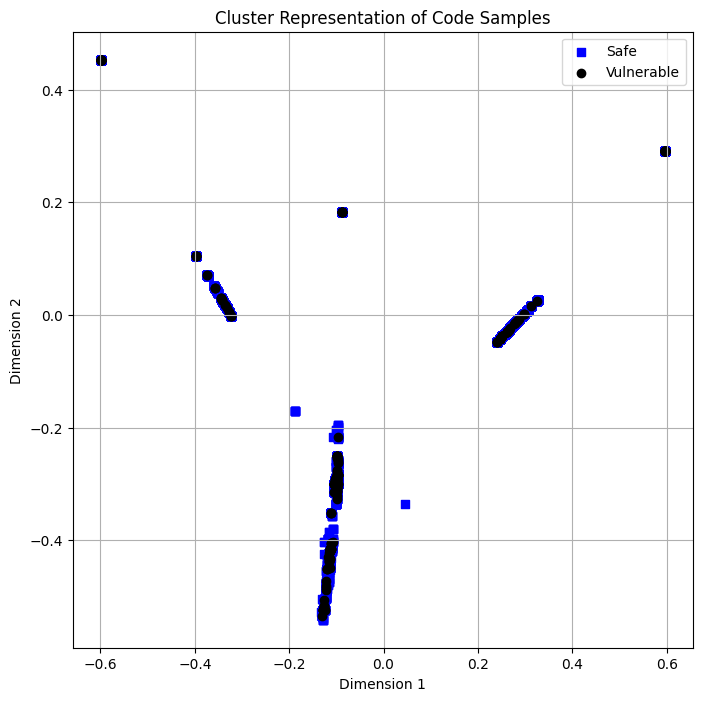

In [5]:
# Convert code text to numeric features
vectorizer = TfidfVectorizer(max_features=500)
X_features = vectorizer.fit_transform(df["codeLink"].astype(str))

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_cluster = pca.fit_transform(X_features.toarray())

labels = df["vul"].values

plt.figure(figsize=(8,8))

# Safe = Blue squares
plt.scatter(
    X_cluster[labels == 0, 0],
    X_cluster[labels == 0, 1],
    c='blue',
    marker='s',
    label='Safe'
)

# Vulnerable = Black circles
plt.scatter(
    X_cluster[labels == 1, 0],
    X_cluster[labels == 1, 1],
    c='black',
    marker='o',
    label='Vulnerable'
)

plt.title("Cluster Representation of Code Samples")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
MODEL_NAME = "microsoft/codebert-base"
LEARNING_RATE = 0.001
EPOCHS = 5
BATCH_SIZE = 8
TEST_SIZE = 0.2
RANDOM_SEED = 42


In [7]:
# dataset class
class CodeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [8]:
#metric computation
accuracy_history = []
loss_history = []

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average="binary")

    accuracy_history.append(acc)

    return {"accuracy": acc, "f1_score": f1}


In [9]:
#data preparation
def prepare_data():
    X = df["codeLink"].astype(str).tolist()
    y = df["vul"].astype(int).tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
    test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=256)

    train_dataset = CodeDataset(train_encodings, y_train)
    test_dataset = CodeDataset(test_encodings, y_test)

    return train_dataset, test_dataset, tokenizer


In [10]:
#custom trainer for batch loss tracking
class CustomTrainer(Trainer):
    def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        inputs = self._prepare_inputs(inputs)

        outputs = model(**inputs)
        loss = outputs.loss

        # store loss
        loss_history.append(loss.item())


        loss.backward()
        return loss.detach()


In [57]:
def train_transformer_model():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_dataset, test_dataset, tokenizer = prepare_data()

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        logging_strategy="epoch",
        eval_strategy="epoch",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print("\n===== TRAINING STARTED =====")
    trainer.train()

    print("\n===== FINAL EVALUATION =====")
    eval_results = trainer.evaluate()

    # Extract loss per epoch
    log_history = trainer.state.log_history

    epoch_losses = []
    epoch_numbers = []

    for log in log_history:
        if "loss" in log and "epoch" in log:
            epoch_losses.append(log["loss"])
            epoch_numbers.append(log["epoch"])

    return model, epoch_numbers, epoch_losses, eval_results


In [58]:
model, epochs, losses, eval_results = train_transformer_model()

Using device: cpu


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/p5/g7gd_mwd10b4r42w413kr3rm0000gn/T/ipykernel_33921/2040105365.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== TRAINING STARTED =====


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.270700,0.221380,0.943000,0.000000
2,0.253100,0.231875,0.943000,0.000000
3,0.240100,0.230209,0.943000,0.000000
4,0.234300,0.220797,0.943000,0.000000
5,0.230700,0.235549,0.943000,0.000000


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argume


===== FINAL EVALUATION =====


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


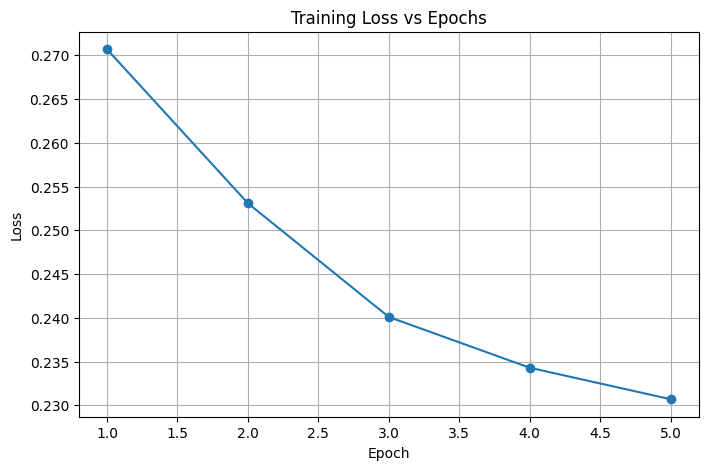

In [59]:
plt.figure(figsize=(8,5))
plt.plot(epochs, losses, marker='o')
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [66]:
def train_transformer_model():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_dataset, test_dataset, tokenizer = prepare_data()

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        logging_strategy="epoch",
        eval_strategy="epoch",
        report_to="none",
        save_strategy="no"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print("\n===== TRAINING STARTED =====")
    trainer.train()

    print("\n===== FINAL EVALUATION =====")
    eval_results = trainer.evaluate()

    # ================= EXTRACT EPOCH METRICS =================
    log_history = trainer.state.log_history

    epochs = []
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for log in log_history:
        if "epoch" in log:
            if "loss" in log:
                epochs.append(log["epoch"])
                train_losses.append(log["loss"])
            if "eval_loss" in log:
                val_losses.append(log["eval_loss"])
            if "eval_accuracy" in log:
                val_accuracies.append(log["eval_accuracy"])

    return model, epochs, train_losses, val_losses, val_accuracies, eval_results


In [67]:
model, epochs, train_losses, val_losses, val_accuracies, eval_results = train_transformer_model()

Using device: cpu


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/p5/g7gd_mwd10b4r42w413kr3rm0000gn/T/ipykernel_33921/2768345587.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== TRAINING STARTED =====


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.269100,0.273510,0.943000,0.000000
2,0.252000,0.227126,0.943000,0.000000
3,0.237000,0.228871,0.943000,0.000000
4,0.229400,0.219749,0.943000,0.000000
5,0.228400,0.231893,0.943000,0.000000


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



===== FINAL EVALUATION =====


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [68]:
val_accuracies

[0.943, 0.943, 0.943, 0.943, 0.943, 0.943]

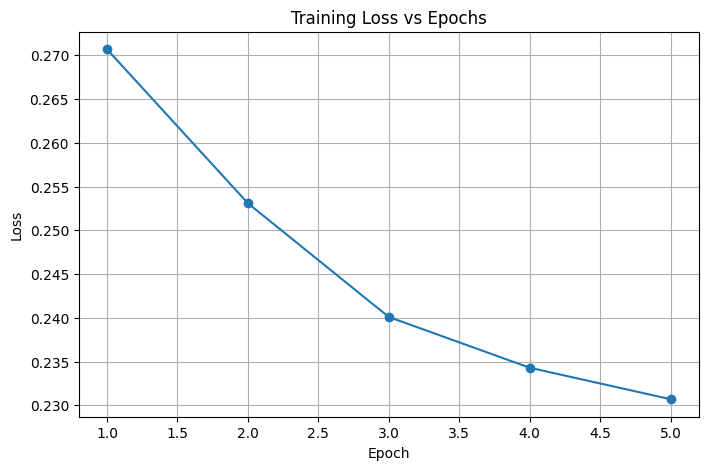

In [69]:
plt.figure(figsize=(8,5))
plt.plot(epochs, losses, marker='o')
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [70]:
print("Epochs:", epochs)
print("Validation Accuracies:", val_accuracies)

Epochs: [1.0, 2.0, 3.0, 4.0, 5.0]
Validation Accuracies: [0.943, 0.943, 0.943, 0.943, 0.943, 0.943]


In [71]:
min_len = min(len(epochs), len(val_accuracies))
epochs_plot = epochs[:min_len]
val_acc_plot = val_accuracies[:min_len]


In [77]:
print("Epochs length:", len(epochs))
print("Val Acc length:", len(val_accuracies))


Epochs length: 5
Val Acc length: 6


In [78]:
min_len_acc = min(len(epochs), len(val_accuracies))
epochs_plot = epochs[:min_len_acc]
val_acc_plot = val_accuracies[:min_len_acc]


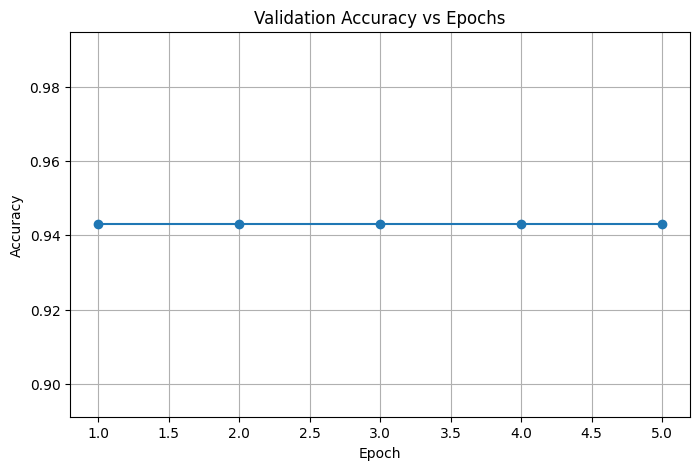

In [80]:
#accuracy vs epochs

plt.figure(figsize=(8,5))
plt.plot(epochs_plot, val_acc_plot, marker='o')
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

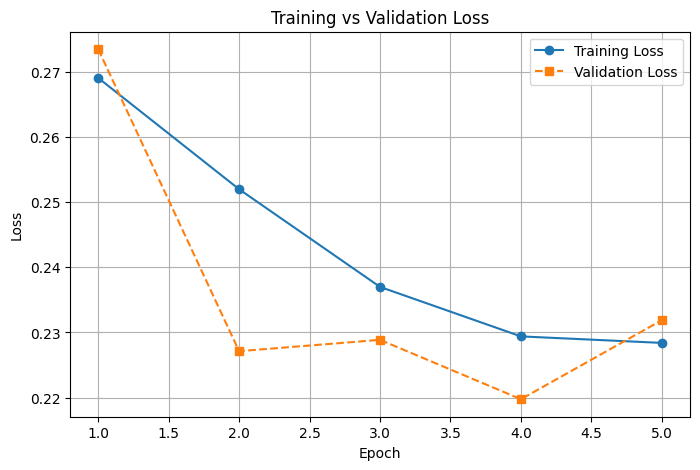

In [81]:
# training vs validation loss comparison 
min_len_loss = min(len(epochs), len(train_losses), len(val_losses))

epochs_plot = epochs[:min_len_loss]
train_loss_plot = train_losses[:min_len_loss]
val_loss_plot = val_losses[:min_len_loss]

plt.figure(figsize=(8,5))
plt.plot(epochs_plot, train_loss_plot, label="Training Loss", marker='o')
plt.plot(epochs_plot, val_loss_plot, label="Validation Loss", linestyle="--", marker='s')

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
#overfitting detection plot

min_len = min(len(epochs), len(train_losses), len(val_losses))

epochs_plot = epochs[:min_len]
train_loss_plot = train_losses[:min_len]
val_loss_plot = val_losses[:min_len]

plt.figure(figsize=(8,5))
plt.plot(epochs_plot, train_loss_plot, label="Training Loss")
plt.plot(epochs_plot, val_loss_plot, label="Validation Loss")

plt.fill_between(epochs_plot, train_loss_plot, val_loss_plot, alpha=0.2)

plt.title("Overfitting Detection Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'epochs' is not defined

In [11]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    hidden_dropout_prob=0.3,           # dropout
    attention_probs_dropout_prob=0.3  # dropout
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
#training model using Dropout

def train_transformer_model():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_dataset, test_dataset, tokenizer = prepare_data()

    # ✅ MODEL WITH DROPOUT
    from transformers import AutoConfig
    config = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        config=config
    )
    model.to(device)

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=40,           # ✅ 40 Epochs
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        logging_strategy="epoch",
        eval_strategy="epoch",
        report_to="none",
        save_strategy="no"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print("\n===== TRAINING STARTED =====")
    trainer.train()

    print("\n===== FINAL EVALUATION =====")
    eval_results = trainer.evaluate()

    # ================= EXTRACT EPOCH METRICS =================
    log_history = trainer.state.log_history

    epochs = []
    train_losses = []
    val_losses = []
    val_accuracies = []

    for log in log_history:
        if "epoch" in log:
            if "loss" in log:
                epochs.append(log["epoch"])
                train_losses.append(log["loss"])
            if "eval_loss" in log:
                val_losses.append(log["eval_loss"])
            if "eval_accuracy" in log:
                val_accuracies.append(log["eval_accuracy"])

    return model, epochs, train_losses, val_losses, val_accuracies, eval_results


In [ ]:
model, epochs, train_losses, val_losses, val_accuracies, eval_results = train_transformer_model()

Using device: cpu


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/p5/g7gd_mwd10b4r42w413kr3rm0000gn/T/ipykernel_65766/881120614.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== TRAINING STARTED =====


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.287100,0.290906,0.943000,0.000000
2,0.279900,0.218856,0.943000,0.000000
3,0.275800,0.228720,0.943000,0.000000
4,0.286100,0.219728,0.943000,0.000000
5,0.283300,0.336024,0.943000,0.000000
6,0.278600,0.314127,0.943000,0.000000
7,0.285800,0.327158,0.943000,0.000000
8,0.294800,0.313949,0.943000,0.000000
9,0.292100,0.269404,0.943000,0.000000
10,0.280600,0.229291,0.943000,0.000000


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argume